In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import set_matplotlib_formats
import matplotlib.cm as cm
import hplib as hpl
%matplotlib inline

In [2]:
def getParafast(model,para): #para is the dataframe 'data_key_para.csv' this is a fast method
    para = para.loc[para['Model'] == model]
    parameters=[]
    parameters.append(para['Group'].values.tolist()[0])
    parameters.append(para['p1_P_th [1/°C]'].values.tolist()[0])
    parameters.append(para['p2_P_th [1/°C]'].values.tolist()[0])
    parameters.append(para['p3_P_th [-]'].values.tolist()[0])
    parameters.append(para['p1_P_el [1/°C]'].values.tolist()[0])
    parameters.append(para['p2_P_el [1/°C]'].values.tolist()[0])
    parameters.append(para['p3_P_el [-]'].values.tolist()[0])
    parameters.append(para['p1_COP [-]'].values.tolist()[0])
    parameters.append(para['p2_COP [-]'].values.tolist()[0])
    parameters.append(para['p3_COP [-]'].values.tolist()[0])
    parameters.append(para['P_el_ref [W]'].values.tolist()[0])
    parameters.append(para['P_th_ref [W]'].values.tolist()[0])
    return parameters
def getParaeasy(model): #only with model name you get the data needed for fit. Takes a bit longer
    para = pd.read_csv('hplib-database.csv', delimiter=',')
    para = para.loc[para['Model'] == model]
    parameters=[]
    parameters.append(para['Group'].values.tolist()[0])
    parameters.append(para['p1_P_th [1/°C]'].values.tolist()[0])
    parameters.append(para['p2_P_th [1/°C]'].values.tolist()[0])
    parameters.append(para['p3_P_th [-]'].values.tolist()[0])
    parameters.append(para['p1_P_el [1/°C]'].values.tolist()[0])
    parameters.append(para['p2_P_el [1/°C]'].values.tolist()[0])
    parameters.append(para['p3_P_el [-]'].values.tolist()[0])
    parameters.append(para['p1_COP [-]'].values.tolist()[0])
    parameters.append(para['p2_COP [-]'].values.tolist()[0])
    parameters.append(para['p3_COP [-]'].values.tolist()[0])
    parameters.append(para['P_el_ref [W]'].values.tolist()[0])
    parameters.append(para['P_th_ref [W]'].values.tolist()[0])
    return parameters
def getPowerHP(x,y,parameter): #input is: x -> input temperature
                                        # y -> outflow temperature
                                        #parameter -> list from getpara(easy/fast)
    Group=parameter[0]
    k4=parameter[4]
    k5=parameter[5]
    k6=parameter[6]
    k7=parameter[7]
    k8=parameter[8]
    k9=parameter[9]
    Pel_n=parameter[10]
    Pth_max=parameter[11]
    PSUP=0
    if Group==1 or Group==2 or Group==3:
        COP=k7*x+k8*y+k9
        if x>=5: #minimum electrical Power at 5°C
            x=5
        Pel=(k4*x+k5*y+k6)*Pel_n
        Pth=Pel*COP
        if COP<=1:
            COP=1
            Pel=Pth_max
            Pth=Pth_max
        
    # for subtype = On-Off
    elif Group==4 or Group==5 or Group==6:
        Pel=(k4*x+k5*y+k6)*Pel_n
        COP=k7*x+k8*y+k9
        Pth=Pel*COP
        if COP<=1:
            COP=1
            Pel=Pth_max
            Pth=Pth_max
    # for subtype = Two-stages
    else:
        Pel=0
        COP=0
        Pth=0
        if COP<=1:
            COP=1
            Pel=Pth_max
            Pth=Pth_max
    
    return Pth,Pel,COP

In [3]:
tin=-20
tout=55
getPowerHP(tin,tout,getParaeasy('LW 101'))
#return: Pth, Pel, Psup, COP

(6980.0, 6980.0, 1)

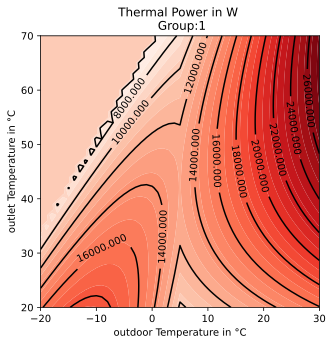

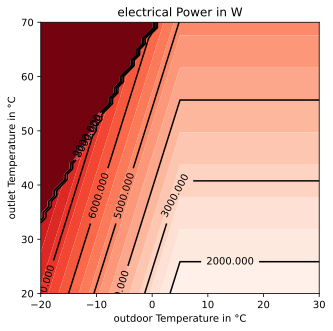

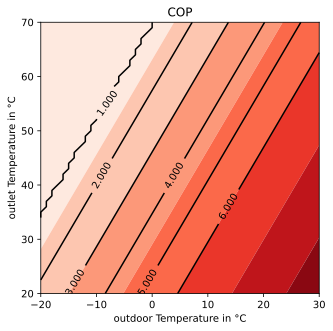

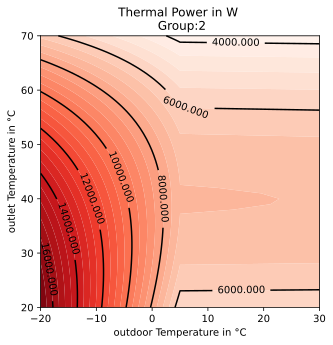

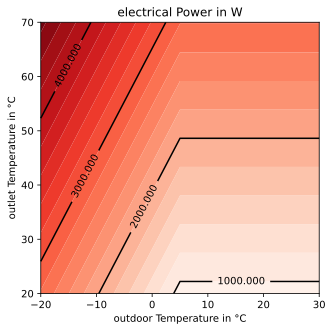

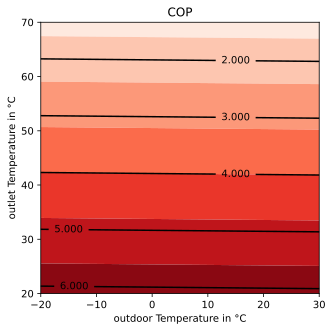

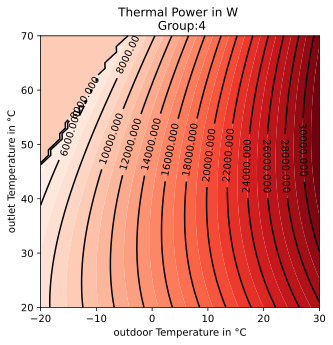

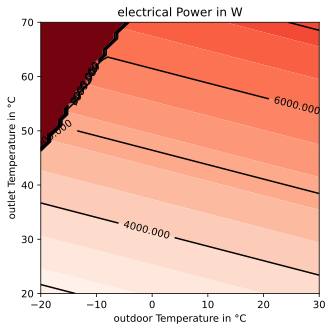

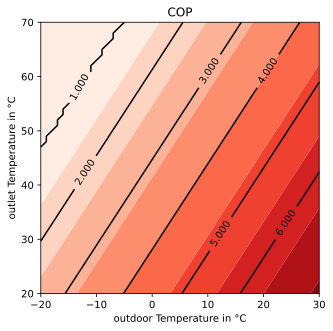

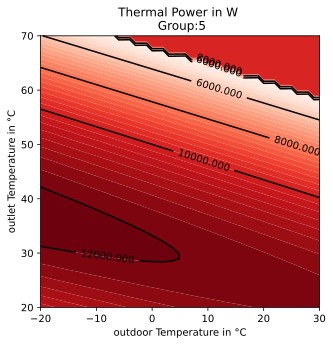

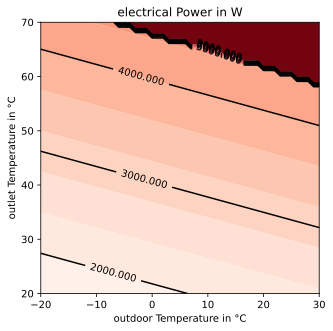

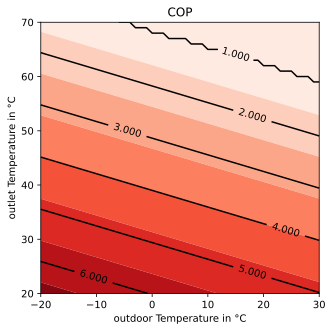

In [16]:
T_low=[*range(-20,31,1)]#inflow TEMP
T_high=[*range(20,71,1)]#outflow TEMP

Groups=[1,2,4,5]
for group in Groups:
    Tin=[]
    Tout=[]
    Pth_keyfit=[]
    Pel_keyfit=[]
    COP_keyfit=[]
    parameter=hpl.getParameters('Generic',group,10000)#LW 101 MHC-V16W/D2RN8-B**** 
    for x in T_low:
        for y in T_high:
            p_th = hpl.simulate(x,y,parameter)[0]
            p_el = hpl.simulate(x,y,parameter)[1]
            cop = hpl.simulate(x,y,parameter)[2]
            Tin.append(x)
            Tout.append(y)
            Pth_keyfit.append(p_th)
            Pel_keyfit.append(p_el)
            COP_keyfit.append(cop)
        
    #create Dataframe for plotting        
    heatingPower=pd.DataFrame()
    heatingPower['Tin']=Tin
    Tin1=Tin
    Tin2=Tin
    Tout1=Tout
    Tout2=Tout
    heatingPower['Tout']=Tout
    heatingPower['Pth']=Pth_keyfit

    Z = heatingPower.pivot_table(index='Tin', columns='Tout', values='Pth').T.values
    Tin_unique = np.sort(heatingPower.Tin.unique())
    Tout_unique = np.sort(heatingPower.Tout.unique())
    Tin, Tout = np.meshgrid(Tin_unique, Tout_unique)
            
    set_matplotlib_formats('svg')
    rcParams['figure.figsize'] = 5, 5 # sets plot size
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Define levels in z-axis where we want lines to appear
    levels = np.array([*range(-10000,50000,2000)])
    # Generate a color mapping of the levels we've specified
    cpf = ax.contourf(Tin,Tout,Z, len(levels), cmap=cm.Reds)
    # Set all level lines to black
    line_colors = ['black' for l in cpf.levels]
    # Make plot and customize axes
    cp = ax.contour(Tin, Tout, Z, levels=levels, colors=line_colors)
    ax.clabel(cp, fontsize=10, colors=line_colors)
    ax.set_title('Thermal Power in W \n Group:'+str(group))
    ax.set_xlabel('outdoor Temperature in °C')
    _ = ax.set_ylabel('outlet Temperature in °C')
    plt.show()
    #create Dataframe for plotting        
    heatingPower=pd.DataFrame()
    heatingPower['Tin']=Tin1
    heatingPower['Tout']=Tout1
    heatingPower['Pel']=Pel_keyfit
    Z = heatingPower.pivot_table(index='Tin', columns='Tout', values='Pel').T.values
    Tin_unique = np.sort(heatingPower.Tin.unique())
    Tout_unique = np.sort(heatingPower.Tout.unique())
    Tin, Tout = np.meshgrid(Tin_unique, Tout_unique)      
    set_matplotlib_formats('svg')
    rcParams['figure.figsize'] = 5, 5 # sets plot size
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Define levels in z-axis where we want lines to appear
    levels = np.array([*range(-1000,20000,1000)])
    # Generate a color mapping of the levels we've specified
    cpf = ax.contourf(Tin,Tout,Z, len(levels), cmap=cm.Reds)
    # Set all level lines to black
    line_colors = ['black' for l in cpf.levels]
    # Make plot and customize axes
    cp = ax.contour(Tin, Tout, Z, levels=levels, colors=line_colors)
    ax.clabel(cp, fontsize=10, colors=line_colors)
    ax.set_title('electrical Power in W')
    ax.set_xlabel('outdoor Temperature in °C')
    _ = ax.set_ylabel('outlet Temperature in °C')
    plt.show()


    heatingPower=pd.DataFrame()
    heatingPower['Tin']=Tin2
    heatingPower['Tout']=Tout2
    heatingPower['COP']=COP_keyfit
    Z = heatingPower.pivot_table(index='Tin', columns='Tout', values='COP').T.values
    Tin_unique = np.sort(heatingPower.Tin.unique())
    Tout_unique = np.sort(heatingPower.Tout.unique())
    Tin, Tout = np.meshgrid(Tin_unique, Tout_unique)      
    set_matplotlib_formats('svg')
    rcParams['figure.figsize'] = 5, 5 # sets plot size
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Define levels in z-axis where we want lines to appear
    levels = np.array([*range(0,7,1)])
    # Generate a color mapping of the levels we've specified
    cpf = ax.contourf(Tin,Tout,Z, len(levels), cmap=cm.Reds)
    # Set all level lines to black
    line_colors = ['black' for l in cpf.levels]
    # Make plot and customize axes
    cp = ax.contour(Tin, Tout, Z, levels=levels, colors=line_colors)
    ax.clabel(cp, fontsize=10, colors=line_colors)
    ax.set_title('COP')
    ax.set_xlabel('outdoor Temperature in °C')
    _ = ax.set_ylabel('outlet Temperature in °C')
    plt.show()

In [52]:
data_key = pd.read_csv('hplib-database.csv', delimiter=',')
group=5
data_key=data_key.loc[data_key['Group']==group]
Models=data_key['Model'].values.tolist()
Models = list(dict.fromkeys(Models))

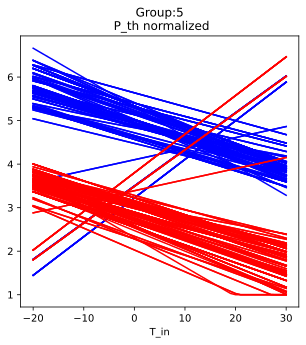

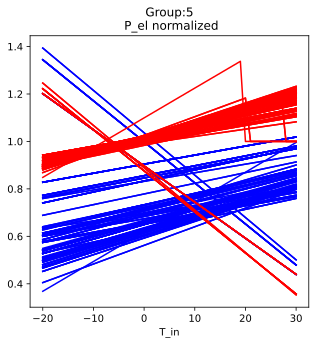

In [53]:
T_in=[*range(-20,31,1)]#inflow TEMP
T_out=[30,50]
paradf = pd.read_csv('hplib-database.csv', delimiter=',')
paradf=paradf.loc[paradf['Group']==group]
P_th_low_g=pd.DataFrame()
P_th_low_g['T_in']=T_in
P_th_high_g=pd.DataFrame()
P_th_high_g['T_in']=T_in
P_el_low_g=pd.DataFrame()
P_el_low_g['T_in']=T_in
P_el_high_g=pd.DataFrame()
P_el_high_g['T_in']=T_in

for model in Models:
    P_th_low=[]
    P_th_high=[]
    P_el_low=[]
    P_el_high=[]
    para=getParafast(model,paradf)
    for tin in T_in:
        p_th_low=getPowerHP(tin,T_out[0],para)[2]
        p_th_high=getPowerHP(tin,T_out[1],para)[2]
        p_el_low=getPowerHP(tin,T_out[0],para)[1]
        p_el_high=getPowerHP(tin,T_out[1],para)[1]
        P_th_low.append(p_th_low)
        P_th_high.append(p_th_high)
        P_el_low.append(p_el_low)
        P_el_high.append(p_el_high)
    P_th_low_g[model]=P_th_low
    P_th_high_g[model]=P_th_high
    P_el_low_g[model]=P_el_low
    P_el_high_g[model]=P_el_high
#Plot: thermal power
fig, axes = plt.subplots(nrows=1, ncols=1)
variable=str(group)
P_th_low_g.plot(ax=axes, x='T_in', y=Models, kind='line', c='Blue', title='Group:' + variable + '\n P_th normalized', legend=False)
P_th_high_g.plot(ax=axes, x='T_in', y=Models, kind='line', c='Red', legend=False)
plt.show()

#Plot: electric Power
fig, axes = plt.subplots(nrows=1, ncols=1)
P_el_low_g.plot(ax=axes, x='T_in', y=Models, kind='line', c='Blue', title='Group:' + variable + '\n P_el normalized', legend=False)
P_el_high_g.plot(ax=axes, x='T_in', y=Models, kind='line', c='Red', legend=False)
plt.show()